# Homework 1
## Bradly T Booth

In this assignment, we will be exploring the car dataset and analyzing their fuel efficiency. <br >
Specifically, we will do some exploratory analysis with visualizations, then we will build a model for Simple Linear Regression, a model for Polynomial Regression, and one model for Logistic Regression. <br >
**The given dataset is already modified and cleaned**, but you can find [the original information here.](https://archive.ics.uci.edu/ml/datasets/auto+mpg).

## Dataset Attribute Information

1. **mpg**: Miles per gallon. This is one primary measurement for car fuel efficiency.
2. **displacement** : The cylinder volumes in cubic inches.
3. **horsepower** : Engine power.
4. **weight** : In pounds.
5. **acceleration** : The elapsed time in seconds to go from 0 to 60mph.
6. **origin** : Region of origin.

### Libraries that can be used: numpy, pandas, scikit-learn, seaborn, plotly, matplotlib
Any libraries used in the discussion materials are also allowed.

#### Other Notes
 - Don't worry about not being able to achieve high accuracy, it is neither the goal nor the grading standard of **this** assignment. <br >
 - If not specified, you are not required to do hyperparameter tuning, but feel free to do so if you'd like.
 - Discussion materials should be helpful for doing the assignments.

# Exercises
## Exercise 1 - Exploratory Analysis (20 points in total)

### Exercise 1.1 - Correlation Matrix (10 points)
Generate a Pearson [correlation matrix plot](https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07) in the form of a heatmap. See the link to have an idea about what this visualization should look like. <br >
After generating the plot, answer the following question: <br >
**If we are going to predict ``mpg`` in Simple Linear Regression(i.e., $y=ax+b$), which attribute are you most UNLIKELY to pick as the independent variable? Explain why.**

Requirements & notes
 - When computing correlation, make sure to drop the column ``origin`` to avoid errors.
 - The computed correlation values should be shown on the plot.
 - Use a diverging color scale with the color range being \[-1, 1\] and center being 0 (if applicable).

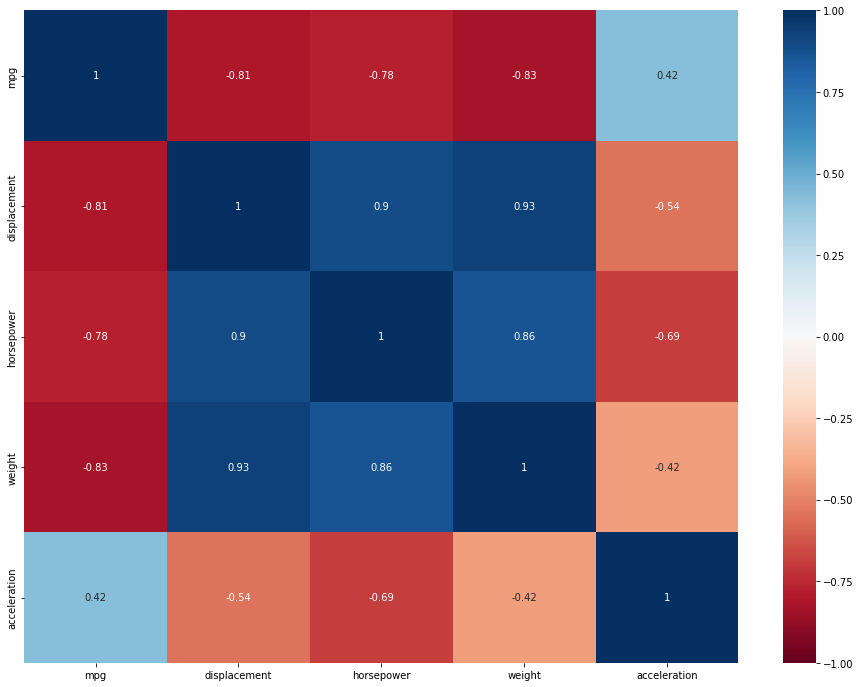

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
df = pd.read_csv('auto-mpg.csv')
corr = df
corr = corr.drop(columns="origin")
corr = corr.corr()    #Need to look up this function call but it looks like it just does some work
                    #on each to find a correlation between var in dataset
plt.figure(figsize=(16, 12)) #What is this function even doing?  Is it just making room on the page?
_ = sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True, cmap= 'RdBu')

# Exercise 1.1 Answer
If I were going to try to predict mpg, I would be least likely to pick acceleration as an independant variable.  Displacement, horsepower and weight all have a strong correlation to mpg.  

### Exercise 1.2 - Pairplot (10 points)
Generate a pairplot(a.k.a. scatter plot matrix) of the given dataset. <br >
After generating the plot, answer the following question: <br >
**If we are using ``horsepower`` to predict ``mpg``, which method could lead to the best performance? (Linear Regression, Polynomial Regression, or Logistic Regression) Explain why.**

Note that there is no requirement on the diagonals. You can leave empty or use other representations based on your preference. However, having ``origin``-based grouped data distributions on the diagonals effectively helps you answer some questions in the later exercises.   

Requirements
 - The points should be colored based on the column ``origin``.

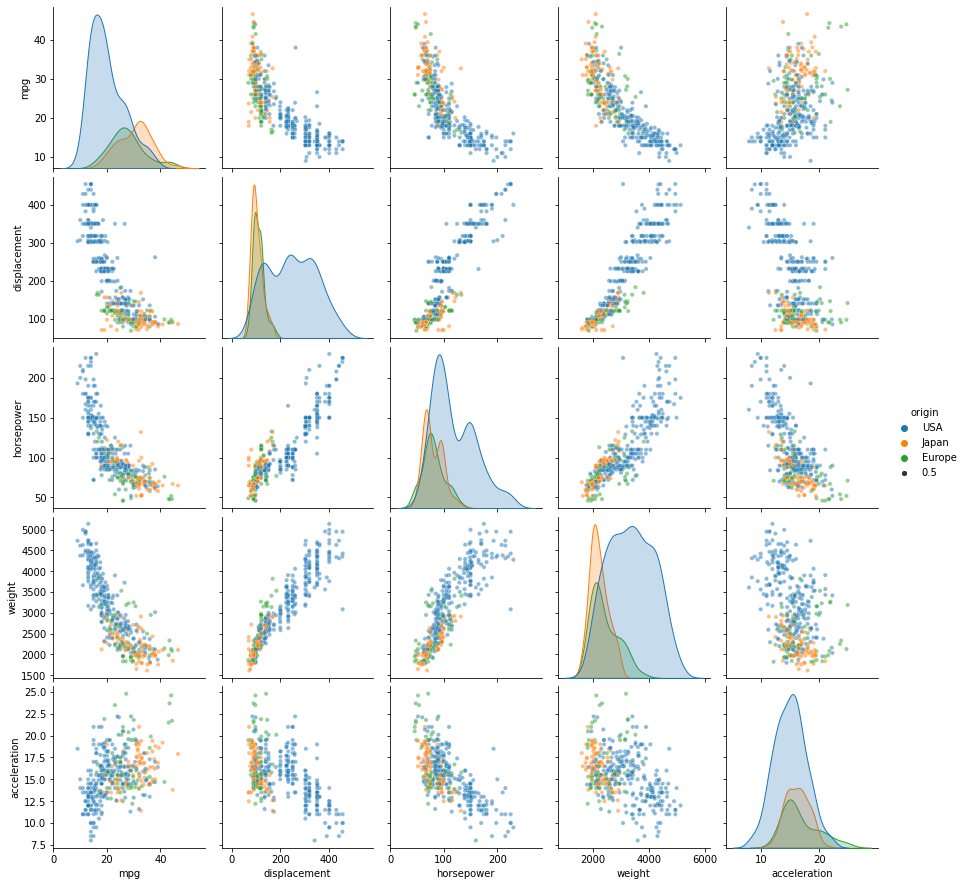

In [2]:
sns.pairplot(data=df,
            hue='origin',
            vars=['mpg','displacement','horsepower','weight','acceleration'],
            diag_kind='kde',
            plot_kws=dict(size=.5, alpha=.5)
            )

# 2.1 Answer
I feel like the best regression here would log.  The asymtote on the scatterplot is what would make me want to try fitting the data to a log function.  Additionly, as horsepower increases, mpg seems to be decreasing towards 0.  

### Ammendment
I wrote the above answer before learning what logerithmic was.  While I still believe you could fit these data points to logarithmic function, logarithmic regression is not the right tool.  I would say that polynomial regression is the best tool for the job.  

## Exercise 2 - Linear and Polynomial Regression (40 points in total)

### Exercise 2.1 - Splitting Dataset (5 points)
Split the data into training and testing set with the ratio of 80:20.

In [3]:
from sklearn.model_selection import train_test_split

#random_state: Controls the shuffling applied to the data before applying the split. 
#Pass an int for reproducible output across multiple function calls.
train, test = train_test_split(df, test_size=0.2, random_state=21)
print("Training Set")
print(train)
print("Test Set")
print(test)

Training Set
      mpg  displacement  horsepower  weight  acceleration  origin
380  25.0         181.0       110.0  2945.0          16.4     USA
6    14.0         454.0       220.0  4354.0           9.0     USA
191  24.0         200.0        81.0  3012.0          17.6     USA
77   21.0         120.0        87.0  2979.0          19.5  Europe
219  17.5         305.0       145.0  3880.0          12.5     USA
..    ...           ...         ...     ...           ...     ...
368  24.0         140.0        92.0  2865.0          16.4     USA
48   23.0         122.0        86.0  2220.0          14.0     USA
260  19.2         305.0       145.0  3425.0          13.2     USA
312  26.4         140.0        88.0  2870.0          18.1     USA
207  19.0         120.0        88.0  3270.0          21.9  Europe

[313 rows x 6 columns]
Test Set
      mpg  displacement  horsepower  weight  acceleration  origin
195  29.0          90.0        70.0  1937.0          14.2  Europe
55   26.0          91.0       

In [4]:
#We are going to try to predict mpg from weight of vehicle
#This is splitting up data set further so we only have the columns of weight and mpg
x_train = train['weight']
x_test = test['weight']
y_train = train['mpg']
y_test = test['mpg']
print(x_train)

380    2945.0
6      4354.0
191    3012.0
77     2979.0
219    3880.0
        ...  
368    2865.0
48     2220.0
260    3425.0
312    2870.0
207    3270.0
Name: weight, Length: 313, dtype: float64


### Exercise 2.2 - Simple Linear Regression (10 points)
Using one of the other attributes(excluding ``origin``) by your choice, please build a simple linear regression model that predicts ``mpg``. <br >

Requirements
 - Report the testing MSE error.

In [5]:
import numpy as np
import random
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
import pdb
from sklearn.metrics import mean_squared_error


def batchGD(epochs=100, batchSize=20):
    reg = SGDRegressor()  #I think this is making an SGDRegressor object name reg

    costHist = []
    
    if(int(len(x_train)/batchSize) > len(x_train)/batchSize 
       and int(len(x_train)/batchSize) > len(x_train)/batchSize):
        loopCount = int(len(x_train)/batchSize) + 1
    else:
        loopCount = int(len(x_train)/batchSize)
    
    for epoch in range(0,epochs):
        indexes = list(range(x_train.size))
        random.shuffle(indexes)
        #print(indexes)
        shuffledX = x_train.iloc[indexes]
        shuffledY = y_train.iloc[indexes]
        
        for i in range(int(len(x_train)/batchSize)): #if we wanted to make this a function, make the 20 a var.

            begin = batchSize*i
            if(batchSize*(i+1) > len(x_train)):
                end = len(x_train)
            else:
                end = (batchSize*(i+1))
            #print(begin)
            #print(end)
            x_part = np.asarray(shuffledX[begin:end]).reshape(-1,1)
            y_part = shuffledY[begin:end]
            
            #print(x_part)
            reg.partial_fit(x_part, y_part)
        y_pred = reg.predict(X=np.asarray(x_train).reshape(-1, 1))
        #print(y_pred)
        #print(y_part)
        costHist.append(mean_squared_error(y_train, y_pred))

    #y_pred = reg.predict(X=np.asarray(x_train).reshape(-1, 1))
    mse = mean_squared_error(y_train, y_pred)
    return x_train, y_pred, costHist
 



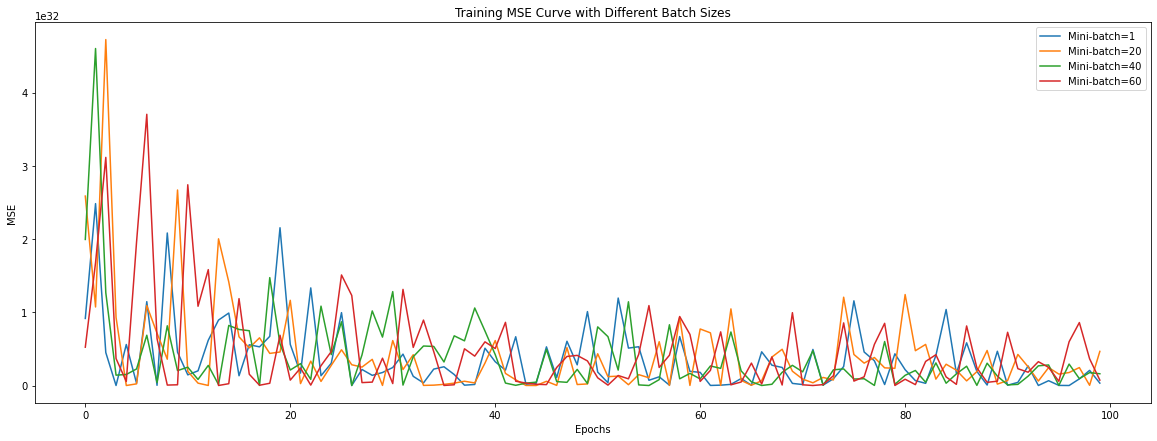

In [6]:
plt.figure(figsize=(20,7))
for batch_size in [1, 20, 40, 60]:
    x1, y2, costHis = batchGD(batchSize=batch_size)
    #plt.scatter(x=x1, y = y_train)
    #plt.scatter(x=x1, y = y2)
    plt.plot(costHis, label=f'Mini-batch={batch_size}')

plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training MSE Curve with Different Batch Sizes')
plt.legend()
plt.show()

### Exercise 2.3 - Polynomial Regression (25 points)
Build polynomial regression models that predict ``mpg`` with the same choice in 2.2. <br >
Specifically, from degree=2 to degree=4, build one respectively. <br >
Then, based on the reported errors from only these three degrees, **do you think there is a sign of overfitting? Provide your reasoning.**


Requirements
 - Report the training MSE error for each of the three degrees.
 - Report the testing MSE error for each of the three degrees.


3 Degree Mean Squared Error
MSE Train: 17.8243884975306
MSE Test: 15.286926955207399


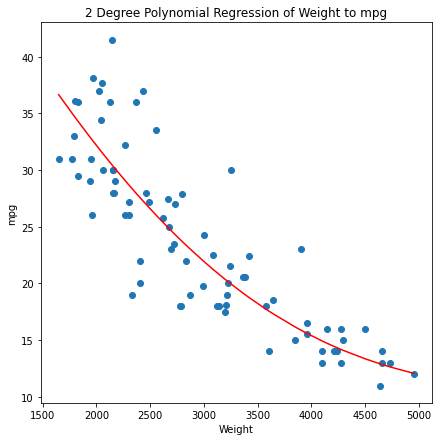

3 Degree Mean Squared Error
MSE Train: 18.07535637795976
MSE Test: 15.011092855591349


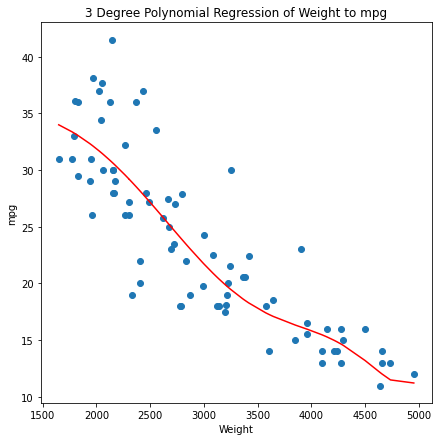

4 Degree Mean Squared Error
MSE Train: 24.254979093556685
MSE Test: 22.204041701246982


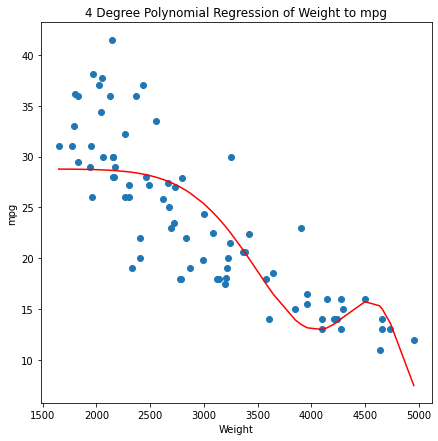

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from IPython.display import display
from numpy import reshape
import operator

poly = PolynomialFeatures(2)
polyreg = make_pipeline(PolynomialFeatures(2), LinearRegression())
x_poly = np.asarray(x_train).reshape(-1,1)
x_poly = poly.fit_transform(x_poly)

yTemp = np.asarray(y_train)
yTemp = yTemp.reshape(-1,1)


polyreg.fit(x_poly, yTemp)

x_polyTest = np.asarray(x_test).reshape(-1,1)
x_polyTest = poly.fit_transform(x_polyTest)
y_pred = polyreg.predict(x_polyTest)

mseTrain = mean_squared_error(np.asarray(y_train), polyreg.predict(x_poly))
mseTest = mean_squared_error(np.asarray(y_test), y_pred)
print("3 Degree Mean Squared Error")
print("MSE Train: " + str(mseTrain))
print("MSE Test: " + str(mseTest))

sorted_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x_test, y_pred), key=sorted_axis)
x_polyTest, y_pred = zip(*sorted_zip)


plt.figure(figsize = (7,7))
plt.xlabel("Weight")
plt.ylabel("mpg")
plt.scatter(x_test, y_test)
plt.plot(x_polyTest, y_pred, color="red")
plt.title("2 Degree Polynomial Regression of Weight to mpg")
plt.show()

poly = PolynomialFeatures(3)
polyreg = make_pipeline(PolynomialFeatures(3), LinearRegression())

x_poly = np.asarray(x_train).reshape(-1,1)
x_poly = poly.fit_transform(x_poly)

yTemp = np.asarray(y_train)
yTemp = yTemp.reshape(-1,1)


polyreg.fit(x_poly, yTemp)

x_polyTest = np.asarray(x_test).reshape(-1,1)
x_polyTest = poly.fit_transform(x_polyTest)
y_pred = polyreg.predict(x_polyTest)

mseTrain = mean_squared_error(np.asarray(y_train), polyreg.predict(x_poly))
mseTest = mean_squared_error(np.asarray(y_test), y_pred)
print("3 Degree Mean Squared Error")
print("MSE Train: " + str(mseTrain))
print("MSE Test: " + str(mseTest))

sorted_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x_test, y_pred), key=sorted_axis)
x_polyTest, y_pred = zip(*sorted_zip)

plt.figure(figsize = (7,7))
plt.scatter(x_test, y_test)
plt.plot(x_polyTest, y_pred, color="red")
plt.title("3 Degree Polynomial Regression of Weight to mpg")
plt.xlabel("Weight")
plt.ylabel("mpg")
plt.show()

poly = PolynomialFeatures(4)
polyreg = make_pipeline(PolynomialFeatures(4), LinearRegression())

x_poly = np.asarray(x_train).reshape(-1,1)
x_poly = poly.fit_transform(x_poly)

yTemp = np.asarray(y_train)
yTemp = yTemp.reshape(-1,1)


polyreg.fit(x_poly, yTemp)

x_polyTest = np.asarray(x_test).reshape(-1,1)
x_polyTest = poly.fit_transform(x_polyTest)
y_pred = polyreg.predict(x_polyTest)

mseTrain = mean_squared_error(np.asarray(y_train), polyreg.predict(x_poly))
mseTest = mean_squared_error(np.asarray(y_test), y_pred)
print("4 Degree Mean Squared Error")
print("MSE Train: " + str(mseTrain))
print("MSE Test: " + str(mseTest))

sorted_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x_test, y_pred), key=sorted_axis)
x_polyTest, y_pred = zip(*sorted_zip)

plt.figure(figsize = (7,7))
plt.scatter(x_test, y_test)
plt.plot(x_polyTest, y_pred, color="red")
plt.title("4 Degree Polynomial Regression of Weight to mpg")
plt.xlabel("Weight")
plt.ylabel("mpg")
plt.show()

## 2.3 Answer
I do not think any is overfitted.  All test and training means seems to be relatively close to each other.

## Exercise 3 - Logistic Regression (40 points in total)

Now we are going to build a classification model on ``origin`` using all the other 5 attributes. <br >
Note that Logistic Regression is a binary classificaiton algorithm.

### Exercise 3.1 - Processing and Splitting the Dataset (10 points)
In this exercise 3, we only consider those observations where they originate from either "USA" or "Japan". <br >
So please **remove** those observations that originate from "Europe". <br >
And then, split the data into training and testing set with the ratio of 80:20. <br >


In [24]:
df = df.drop(df[df.origin == 'Europe'].index)
print(df)
df['OriginBool'] = np.where(df['origin']== 'USA', True, False)
df = df.drop(columns = 'origin')
train, test = train_test_split(df, test_size=0.2, random_state=21)

print("Training Set")
print(train)
print("Test Set")
print(test)

      mpg  displacement  horsepower  weight  acceleration origin
0    18.0         307.0       130.0  3504.0          12.0    USA
1    15.0         350.0       165.0  3693.0          11.5    USA
2    18.0         318.0       150.0  3436.0          11.0    USA
3    16.0         304.0       150.0  3433.0          12.0    USA
4    17.0         302.0       140.0  3449.0          10.5    USA
..    ...           ...         ...     ...           ...    ...
386  27.0         151.0        90.0  2950.0          17.3    USA
387  27.0         140.0        86.0  2790.0          15.6    USA
389  32.0         135.0        84.0  2295.0          11.6    USA
390  28.0         120.0        79.0  2625.0          18.6    USA
391  31.0         119.0        82.0  2720.0          19.4    USA

[324 rows x 6 columns]
Training Set
      mpg  displacement  horsepower  weight  acceleration  OriginBool
138  14.0         304.0       150.0  4257.0          15.5        True
56   24.0         113.0        95.0  2278.0

In [31]:
yTrain = train['OriginBool']
yTest = test['OriginBool']
xTrain = train.drop(columns = 'OriginBool')
xTest = test.drop(columns = 'OriginBool')
print("xTrain")
print(xTrain)

print("yTrain")
print(yTrain)

print("xTest")
print(xTest)

print("yTest" precision    recall  f1-sc)
print(yTest)

xTrain
      mpg  displacement  horsepower  weight  acceleration
138  14.0         304.0       150.0  4257.0          15.5
56   24.0         113.0        95.0  2278.0          15.5
163  20.0         262.0       110.0  3221.0          13.5
374  36.0         120.0        88.0  2160.0          14.5
70   19.0          70.0        97.0  2330.0          13.5
..    ...           ...         ...     ...           ...
144  28.0          90.0        75.0  2125.0          14.5
57   25.0          97.5        80.0  2126.0          17.0
317  31.3         120.0        75.0  2542.0          17.5
379  38.0          91.0        67.0  1995.0          16.2
253  25.1         140.0        88.0  2720.0          15.4

[259 rows x 5 columns]
yTrain
138     True
56     False
163     True
374    False
70     False
       ...  
144     True
57      True
317    False
379    False
253     True
Name: OriginBool, Length: 259, dtype: bool
xTest
      mpg  displacement  horsepower  weight  acceleration
268  21.1       

### Exercise 3.2 - Logistic Regression (30 points)

Using all the other 5 attributes, please build a Logistic Regression model that distinguishes between cars from Japan and cars from the USA. <br >
Then, **if we are distinguishing between Japan and Europe this time, how do you think the model performance(in terms of accuracy) will change? Provide your reasoning.** (Hint: Exercise 1)

Requirements
 - Report the testing precision and recall for both regions.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

model = LogisticRegression()
model = model.fit(xTrain, yTrain)
yPred = model.predict(xTest)
print(classification_report(yTest, yPred,))
print("True = USA, False = Japan")

              precision    recall  f1-score   support

       False       0.81      0.62      0.70        21
        True       0.84      0.93      0.88        44

    accuracy                           0.83        65
   macro avg       0.82      0.78      0.79        65
weighted avg       0.83      0.83      0.82        65

True = USA, False = Japan


I think if you did log regression Japan vs European cars, the accuracy would be a lot lower.  There is an obvious clustering between USA vs Japan or USA vs European cars in almost every category.  I imagine this has to do with "truck and SUV culture" in America vs other countries.  This clustering is not so obvious with Japanese and European cars, where their data points are closer in relation.  I imagine that the accuracy would be closer to 50%.